In [1]:
import sys
sys.path.append('../..')
from src.pomdp import *

# Model

In [2]:
### physical space, the origin is assumed to be the lower-left corner
xboxsize = 45   # in
yboxsize = 35
Nx = 46  # dx =  1 in
Ny = 36  

# la griglia fisica e' il quadrante upper-right
max_v_swim = 2. #in/s
v_walk = 0.2 # in/s
r = 2 # radius cm
dx = xboxsize/(Nx-1)
# dt = dx/v_walk
dt = 0.5 # MODIFIED
max_range = dt*max_v_swim
nrange = int(max_v_swim/v_walk)

### state space definition
Mx = Nx * 2 -1
My = Ny * 2 -1
xmin, xmax, ymin, ymax = - xboxsize, xboxsize, -yboxsize, yboxsize
xp = np.linspace(xmin,xmax,Mx,endpoint=True)  # state space coordinates
yp = np.linspace(ymin,ymax,My,endpoint=True)
X,Y = np.meshgrid(xp,yp)  # space state grid

In [3]:
X

array([[-45., -44., -43., ...,  43.,  44.,  45.],
       [-45., -44., -43., ...,  43.,  44.,  45.],
       [-45., -44., -43., ...,  43.,  44.,  45.],
       ...,
       [-45., -44., -43., ...,  43.,  44.,  45.],
       [-45., -44., -43., ...,  43.,  44.,  45.],
       [-45., -44., -43., ...,  43.,  44.,  45.]])

In [3]:
# definition of swimming steps
move = []
for i in range(-nrange,nrange+1):
    for j in range(-nrange,nrange+1):
        if (i**2+j**2)*dx**2 == max_range**2: move.append((i,j)) # Only at max range
        # if (i**2+j**2)*dx**2 <= max_range**2: move.append((i,j))

print(f'Available actions: {len(move)}')
# for m in move:
#     print(m)

Available actions: 4


In [4]:
### definition of likelihood, likelihood is defined in the state space
# the likelihood will be defined on the grid state space
likelihood_center = (0,0)
def constant_disk(x,y,xs,ys,r):
    d = np.sqrt((x-xs)**2+(y-ys)**2)
    return np.heaviside(r-d,1)
like = constant_disk(X,Y,likelihood_center[0],likelihood_center[1],r)
env_shape = like.shape

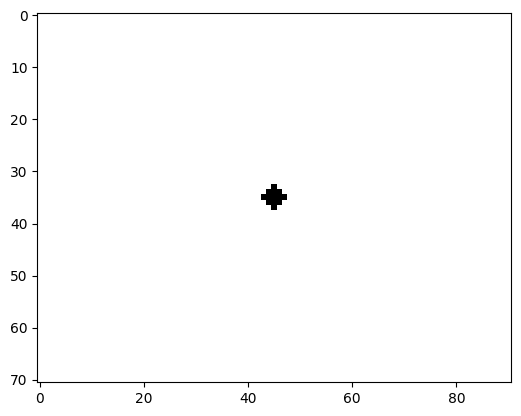

In [5]:
plt.imshow(like, cmap='Greys')

In [6]:
### POMDP states definition
state_grid = []  # this is a list of My lists of Mx strings (state labels) each
# State labels
for i in range(env_shape[0]): # My
    i_states = []
    for j in range(env_shape[1]): # Mx
        i_states.append(f's_{i}_{j}') # s_yind_xind
    state_grid.append(i_states)
state_count = Mx * My

In [7]:
reachable_states = np.full(shape=(state_count, len(move)), fill_value=-1)

for x in range(env_shape[0]):
    for y in range(env_shape[1]):
        for a, m in enumerate(move):
            pos = np.array([x,y])
            m = np.array(m)

            new_pos = pos + m

            # Handle border for new pos
            new_pos = new_pos % np.array(env_shape)
            new_pos[0] = new_pos[0] + env_shape[0] if new_pos[0] < 0 else new_pos[0]
            new_pos[1] = new_pos[1] + env_shape[1] if new_pos[1] < 0 else new_pos[1]

            # Flatten pos
            flat_pos = (env_shape[1] * pos[0]) + pos[1]
            flat_new_pos = (env_shape[1] * new_pos[0]) + new_pos[1]
            reachable_states[flat_pos, a] = flat_new_pos

reachable_states = reachable_states[:,:,None]

In [8]:
# Reward function
def reward_func(s,a,sn,o):
    return np.where(sn == (Mx*(My-1)/2 + (Mx-1)/2), 1.0, 0.0)

In [9]:
# flatten mette di default tutte le righe una in fila all'altra shape = (shape[0]*shape[1],), [:,None] rende questo vettore riga un matrice con una colonna shape = (shape[0]*shape[1],1)
observations = np.concatenate((like.flatten()[:,None], (1-like.flatten()[:,None])),axis=1)
# shape is (like.shape[0]*like.shape[1],2)
observations = observations.reshape(state_count,1,2).repeat(len(move), axis=1) #Repeat for each action
# observation shape = (number of states,n actions, n observation values)

In [10]:
model = Model(
    states=state_grid,
    actions=move,
    observations=['something', 'nothing'],
    reachable_states=reachable_states,
    rewards=reward_func,
    observation_table=observations,
    end_states=[(Mx*(My-1)/2 + (Mx-1)/2)]
    )

[04/15/2024, 10:51:15] Instantiation of MDP Model:
[04/15/2024, 10:51:15] - 6461 states
[04/15/2024, 10:51:15] - 4 actions
[04/15/2024, 10:51:15] - At most 1 reachable states per state-action pair
[04/15/2024, 10:51:15] - Starting generation of transitions table
[04/15/2024, 10:51:15]     > [Warning] No transition matrix or function provided but reachable states are, so probability to reach any reachable states will "1 / reachable state count" so here: 1.000.
[04/15/2024, 10:51:15]     > Done in 0.000s
[04/15/2024, 10:51:15] - Generation of state grid
[04/15/2024, 10:51:15] - Generating start probabilities table
[04/15/2024, 10:51:15] - Starting computation of reachable state probabilities from transition data
[04/15/2024, 10:51:15]     > Done in 0.000s

[04/15/2024, 10:51:15] POMDP particular parameters:
[04/15/2024, 10:51:15] - 2 observations
[04/15/2024, 10:51:15] - Starting of transitional observations for reachable states table
[04/15/2024, 10:51:15]     > Done in 0.001s
[04/15/20

# MDP solution

In [11]:
from src.mdp import VI_Solver

solver = VI_Solver(eps=1e-3)
solution, history = solver.solve(model, use_gpu=False)

  0%|          | 0/10000 [00:00<?, ?it/s]

[Warning] 'as_grid' parameter set to False but state count is >3 so it will be plotted as a grid


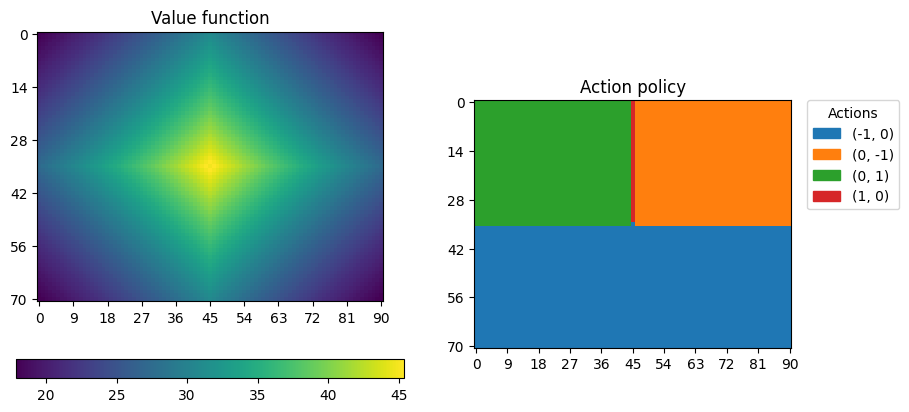

In [12]:
solution.plot()

In [13]:
m_array = np.array(move)

In [14]:
m_array_alt = m_array[:,0] + (m_array[:,1] * 1j)

In [15]:
m_angles = np.angle(m_array_alt)

In [16]:
angle_map = m_angles[solution.actions[np.argmax(solution.alpha_vector_array, axis=0)]].reshape(env_shape)

In [17]:
m_array

array([[-1,  0],
       [ 0, -1],
       [ 0,  1],
       [ 1,  0]])

In [18]:
m_angles

array([ 3.14159265, -1.57079633,  1.57079633,  0.        ])

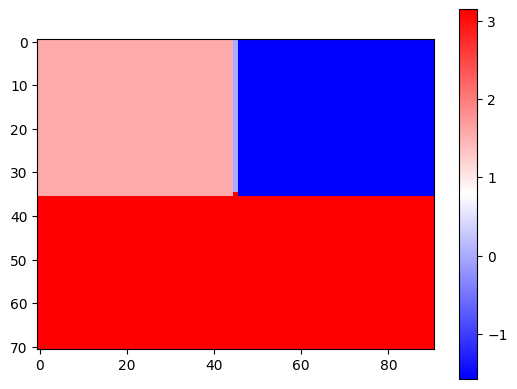

In [19]:
plt.imshow(angle_map, cmap='bwr')
plt.colorbar()

# Training

In [20]:
fsvi_solver = FSVI_Solver(0.99, eps=1e-8, mdp_policy=solution)

fsvi_solution, hist = fsvi_solver.solve(model=model,
                                        max_belief_growth=100,
                                        expansions=200,
                                        print_progress=True,
                                        # expand_prune_level=2,
                                        use_gpu=False)
                                    
print(hist.summary)

Expansions:   0%|          | 0/200 [00:00<?, ?it/s]

Summary of Value Iteration run
  - Model: 6461 state, 4 action, 2 observations
  - Converged or stopped after 200 expansion steps and 200 backup steps.
  - Resulting value function has 2270 alpha vectors.
  - Converged in 281.4942s

  - Expand function took on average 0.0205s and yielded on average 2280.80 beliefs per iteration. (0.0000s/it/belief)
  - Backup function took on average 1.3870s and yielded on average 11.33 alpha vectors per iteration. (0.0012s/it/alpha)
  - Pruning function took on average 0.0001s and yielded on average prunings of 0.00 alpha vectors per iteration.


In [22]:
fsvi_solution.save_parquet(path='./', file_name='sea_robins_vf')

# Test

In [23]:
a = Agent(model=model, value_function=fsvi_solution)

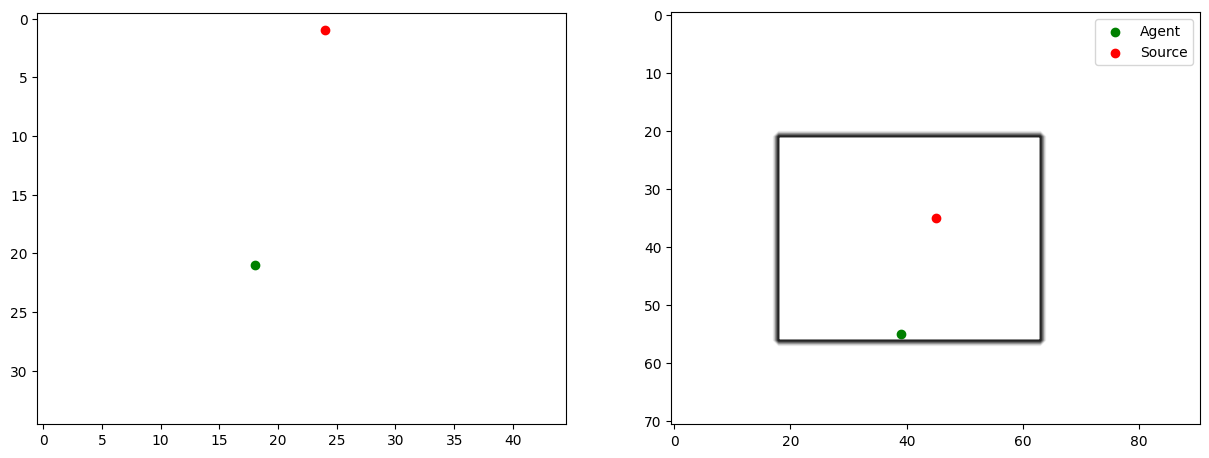

In [30]:
tank_size = np.array([yboxsize, xboxsize])

# PHYSICAL SPACE
source_point = (np.random.random(2) * tank_size).astype(int)
agent_start = (np.random.random(2) * tank_size).astype(int)

fig, (ax0,ax1) = plt.subplots(ncols=2, figsize=(15,10))

ax0.imshow(np.zeros(tank_size), cmap='Greys')
ax0.scatter(source_point[1], source_point[0], c='red', label='Source')
ax0.scatter(agent_start[1], agent_start[0], c='green', label='Agent')

# STATE SPACE
center_state = agent_start
agent_start_state = center_state + (tank_size - source_point)

belief = np.zeros(env_shape)
belief[center_state[0]:center_state[0]+tank_size[0]+1, center_state[1]:center_state[1]+tank_size[1]+1] = 1
belief /= np.sum(belief)

ax1.imshow(np.zeros(env_shape), cmap='Greys')
ax1.contour(belief, cmap='Greys')
# ax1.invert_yaxis()
ax1.scatter(agent_start_state[1], agent_start_state[0], c='green', label='Agent')
ax1.scatter(tank_size[1], tank_size[0], c='red', label='Source')
ax1.legend()

In [31]:
agent_start_flat = (env_shape[1] * agent_start_state[0]) + agent_start_state[1]
hist = a.simulate(start_state=agent_start_flat, initial_belief=Belief(model, belief.flatten()))

  0%|          | 0/1000 [00:00<?, ?it/s]

Simulation done:
	- Runtime (s): 2.621404
	- Steps: 265
	- Total rewards: 1.0
	- End state: s_35_45


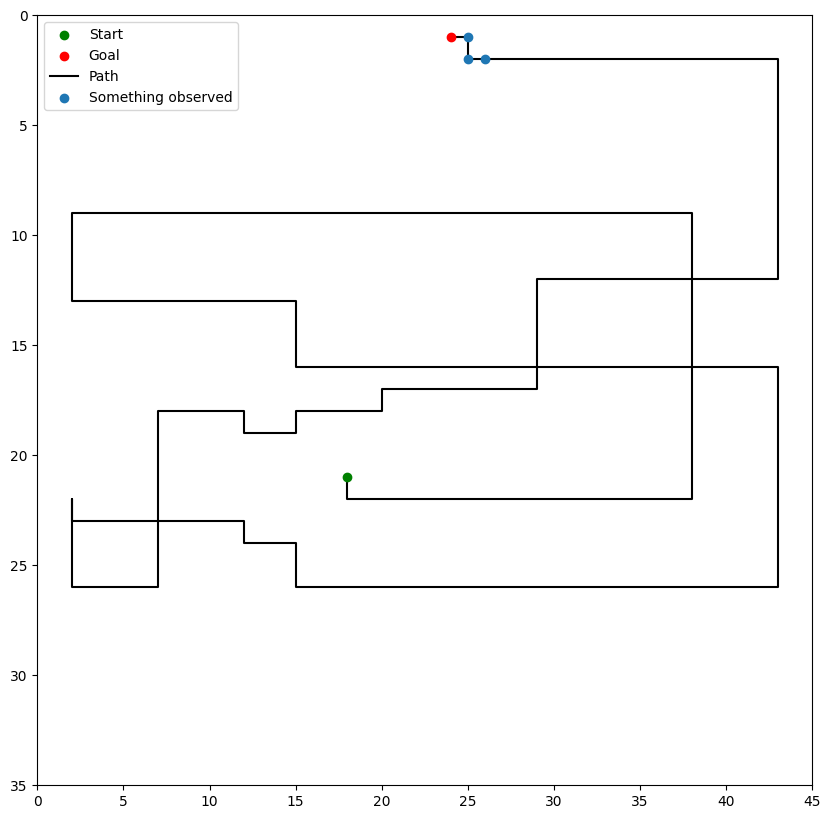

In [32]:
fig, ax = plt.subplots(figsize=(10,10))

# Initial clearing
ax.clear()

# Get cpu model
model = hist.model.cpu_model

# Plot setup
env_shape = model.cpu_model.state_grid.shape
ax.set_xlim(0, tank_size[1])
ax.set_ylim(tank_size[0], 0)

# Compute shift
shift = (hist.grid_point_sequence[0] - agent_start)

# Start
start_coord = hist.grid_point_sequence[0] - shift
ax.scatter(start_coord[1], start_coord[0], c='green', label='Start')

# Goal
goal_coord = source_point[None,:]
ax.scatter(goal_coord[:,1], goal_coord[:,0], c='red', label='Goal')

# Until step
seq = np.array(hist.grid_point_sequence) - shift[None,:]

# Path
ax.plot(seq[:,1], seq[:,0], zorder=-1, c='black', label='Path')

# Something sensed
something_obs_id = model.observation_labels.index('something')
obs_ts = np.where(np.array(hist.observations[:]) == something_obs_id)
points_obs = seq[obs_ts[0],:]
ax.scatter(points_obs[:,1], points_obs[:,0], zorder=1, label='Something observed')

# Generate legend
ax.legend()

# Test for multiple sims

In [33]:
tank_size = np.array([yboxsize, xboxsize])

# Possible start parameters
source_pos_size = np.array([25,15])
source_pos_margins = np.array([5,5])

agent_start_size = np.array([25,1])
agent_start_margins = np.array([5,44])

# Generation of points
n = 1000

source_point = ((np.random.random((n,2)) * source_pos_size[None,:]) + source_pos_margins[None,:]).astype(int)
agent_start = ((np.random.random((n,2)) * agent_start_size[None,:]) + agent_start_margins[None,:]).astype(int)

# STATE SPACE
center_state = agent_start
agent_start_state = center_state + (tank_size[None,:] - source_point)

beliefs = []

for center, start in zip(center_state, agent_start_state):
    belief = np.zeros(env_shape)
    belief[center[0]:center[0]+tank_size[0]+1, center[1]:center[1]+tank_size[1]+1] = 1
    belief /= np.sum(belief)

    beliefs.append(belief.flatten())

beliefs = np.array(beliefs)

agent_start_flat = (env_shape[1] * agent_start_state[:,0]) + agent_start_state[:,1]

In [34]:
# fsvi_solution = ValueFunction.load_from_parquet('./sea_robins_vf.parquet', model=model)

In [35]:
a = Agent(model=model, value_function=fsvi_solution)

In [36]:
_, hist = a.run_n_simulations_parallel(n=len(agent_start_flat),
                                       start_states=agent_start_flat.tolist(),
                                       initial_beliefs=[Belief(model, b) for b in beliefs])

  0%|          | 0/1000 [00:00<?, ?it/s]

All 1000 simulations done in 69.754s:
	- Simulations reached goal: 1000/1000 (0 failures)
	- Average step count: 196.777
	- Average total rewards: 1.0
	- Average discounted rewards (ADR): 0.21862854145918983


In [37]:
# Saving simulation
import json

all_seq = np.empty((len(hist), 1001), dtype=object)
for sim_i, sim in enumerate(hist):
    seq = []
    for s, a, o, r in zip(sim.states, sim.actions+[], sim.observations+[], sim.rewards+[]):
        seq.append(json.dumps({'s':s, 'a':a, 'o':o, 'r':r}))
    
    all_seq[sim_i, :len(seq)] = seq

sim_df = pd.DataFrame(all_seq.T, columns=[f'Sim-{sim_i}' for sim_i in range(len(hist))])
# sim_df.to_csv(f'./run-q_learning_comp-sims.csv')

In [38]:
sim_df.to_csv('./sea_robins-sims-edge_start.csv')

# Analysis of results

In [39]:
import json

In [40]:
sim_df = pd.read_csv('./sea_robins-sims-edge_start.csv', index_col=0)

In [41]:
sims = []
for col in sim_df.columns:
    sim_steps = sim_df[col].tolist()
    sim_steps = [json.loads(step) for step in sim_steps if isinstance(step, str)]

    # Creation of simulation history
    sim_hist = SimulationHistory(model, sim_steps[0]['s'], Belief(model))

    sim_hist.states = [step['s'] for step in sim_steps]
    sim_hist.actions = [step['a'] for step in sim_steps]
    sim_hist.observations = [step['o'] for step in sim_steps]
    sim_hist.rewards = [step['r'] for step in sim_steps]

    sims.append(sim_hist)

In [42]:
tank_size = np.array([yboxsize, xboxsize])

start_states = np.array([s.states[0] for s in sims]).astype(int)
start_pos = np.array([np.unravel_index(start_states, shape=env_shape)])[0].T

opt_traj = np.sum(np.abs(start_pos - tank_size[None,:]), axis=1)

sim_lengths = np.array([len(s) for s in sims])

In [52]:
y_diff = (start_pos - tank_size[None,:])[:,0]
x_diff = (start_pos - tank_size[None,:])[:,1]

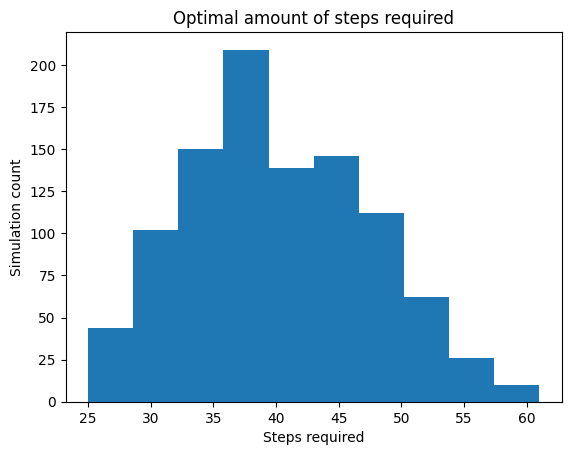

In [43]:
plt.title('Optimal amount of steps required')
plt.hist(opt_traj)
plt.xlabel('Steps required')
plt.ylabel('Simulation count')
plt.show()

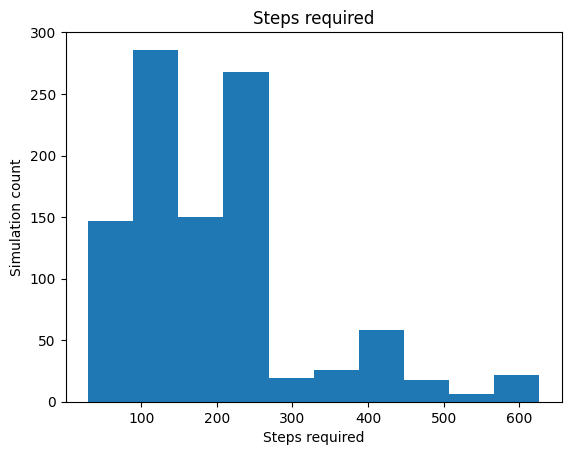

In [44]:
plt.title('Steps required')
plt.hist(sim_lengths)
plt.xlabel('Steps required')
plt.ylabel('Simulation count')
plt.show()

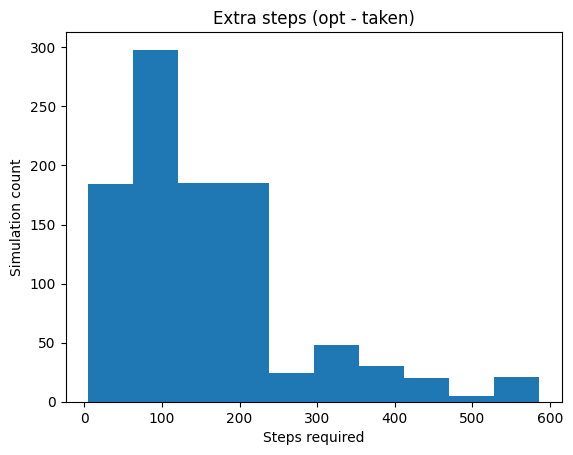

In [45]:
plt.title('Extra steps (opt - taken)')
plt.hist(sim_lengths - opt_traj)
plt.xlabel('Steps required')
plt.ylabel('Simulation count')
plt.show()

Text(0, 0.5, 'Steps taken')

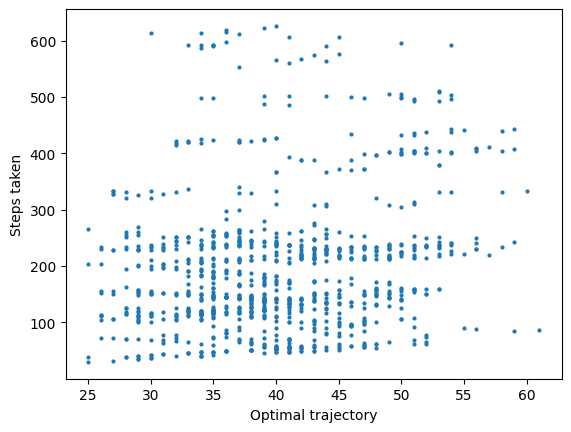

In [48]:
plt.scatter(opt_traj, sim_lengths, s=4)
plt.xlabel('Optimal trajectory')
plt.ylabel('Steps taken')

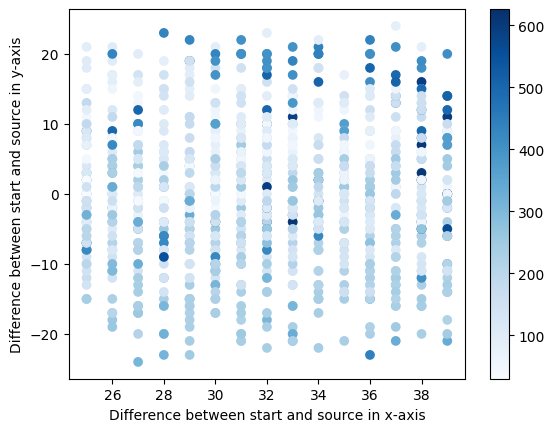

In [56]:
plt.scatter(x=x_diff, y=y_diff, c=sim_lengths, cmap='Blues')
plt.xlabel('Difference between start and source in x-axis')
plt.ylabel('Difference between start and source in y-axis')
plt.colorbar()

Text(0, 0.5, 'Steps taken')

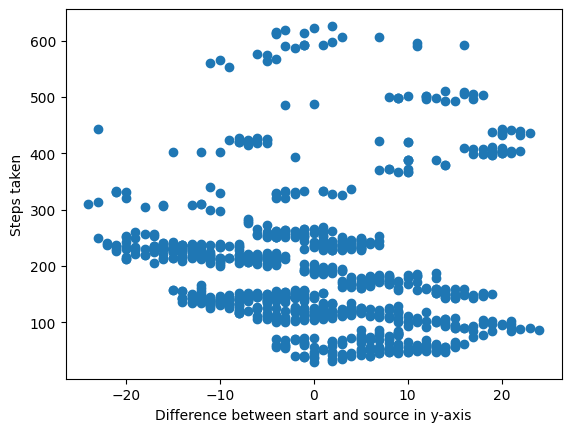

In [58]:
plt.scatter(x=y_diff, y=sim_lengths)
plt.xlabel('Difference between start and source in y-axis')
plt.ylabel('Steps taken')

In [76]:
agent_start[0]

array([23, 44])

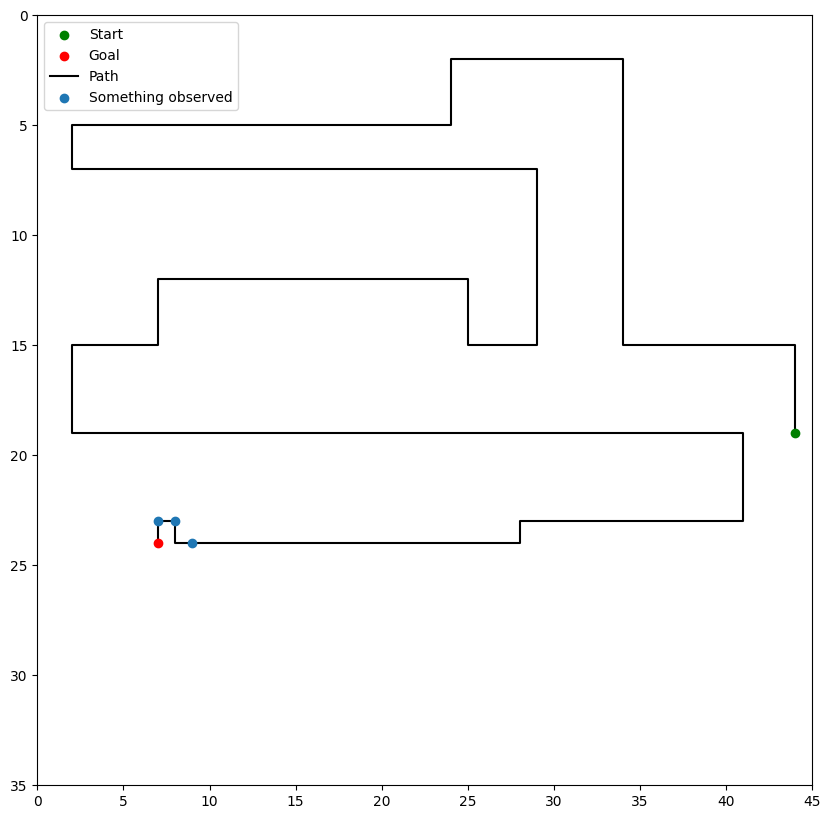

In [86]:
fig, ax = plt.subplots(figsize=(10,10))

sim_n = 11
h = hist[sim_n]
ag_s = agent_start[sim_n]

# Get cpu model
model = h.model.cpu_model

# Plot setup
env_shape = model.cpu_model.state_grid.shape
ax.set_xlim(0, tank_size[1])
ax.set_ylim(tank_size[0], 0)

# Compute shift
shift = (h.grid_point_sequence[0] - ag_s)

# Start
start_coord = h.grid_point_sequence[0] - shift
ax.scatter(start_coord[1], start_coord[0], c='green', label='Start')

# Goal
g_s = h.grid_point_sequence[-1] - shift
ax.scatter(g_s[1], g_s[0], c='red', label='Goal')

# Until step
seq = np.array(h.grid_point_sequence) - shift[None,:]

# Path
ax.plot(seq[:,1], seq[:,0], zorder=-1, c='black', label='Path')

# Something sensed
something_obs_id = model.observation_labels.index('something')
obs_ts = np.where(np.array(h.observations[:]) == something_obs_id)
points_obs = seq[obs_ts[0],:]
ax.scatter(points_obs[:,1], points_obs[:,0], zorder=1, label='Something observed')

# Generate legend
ax.legend()

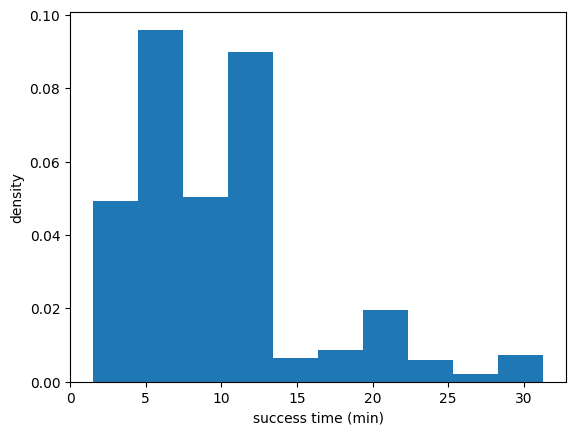

In [92]:
plt.hist((sim_lengths * 3) / 60, density=True)
plt.ylabel('density')
plt.xlabel('success time (min)')
plt.xticks(np.arange(7)*5)
plt.show()

In [94]:
df = pd.DataFrame({'success_time_min': (sim_lengths * 3) / 60})
df.to_csv('./success_times.csv')

: 